In [6]:
import matplotlib.pyplot as plt
from helpers.cm26 import DatasetCM26, operator_Kochkov, operator_coarsen, operator_gaussian
from helpers.computational_tools import select_NA, select_Pacific, select_Cem, select_Equator, StateFunctions, compare
from helpers.ann_tools import ANN, import_ANN, minibatch, export_ANN
import torch
import torch.optim as optim
import numpy as np
from time import time
import json
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ds = DatasetCM26()

In [11]:
ann_Txy = ANN([27, 20, 1])
ann_Txx_Tyy = ANN([27, 20, 2])
log_dict = {}
# ann_Txy = import_ANN('trained_models/ANN_CM26_Kochkov/Txy_epoch_2000.nc')
# ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26_Kochkov/Txx_Tyy_epoch_2000.nc')

In [12]:
num_epochs=1000

all_parameters = list(ann_Txy.parameters()) + list(ann_Txx_Tyy.parameters())
optimizer = optim.Adam(all_parameters, lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
        milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)  

t_s = time()

for epoch in range(num_epochs):
    t_e = time()
    
    training_dataset = ds.sample_epoch(time=np.random.randint(6950), operator=operator_Kochkov) # Approximately 19 years for training
    testing_dataset = ds.sample_epoch(time=np.random.randint(6950,8035), operator=operator_Kochkov) # Approximately 3 years for testing
    print(f'---------- Epoch {epoch} ------------\n')
    
    for factor in [2,4,6,10,20]:
        ############# Training step ################
        def tensor(x, torch_type=torch.float32):
            return torch.tensor(x.values).type(torch_type)
        
        batch = training_dataset[factor]
        # Momentum subgrid forcing
        SGSx = tensor(batch.data.SGSx)
        SGSy = tensor(batch.data.SGSy)
        SGS_norm = float(1. / np.sqrt((SGSx**2 + SGSy**2).mean()))
        SGSx = SGSx * SGS_norm
        SGSy = SGSy * SGS_norm
        
        # Vorticity subgrid forcing
        SGS_RV = batch.state.relative_vorticity_torch(SGSx, SGSy)
        SGS_RV_norm = 1. / torch.sqrt((SGS_RV**2).mean())
        SGS_RV = SGS_RV * SGS_RV_norm
        
        # order of loops is such that the last iteration
        # is standard model without augmentation
        for rotation in [90, 0]:
            for reflect_x in [True, False]:
                for reflect_y in [True, False]:
                    
                    optimizer.zero_grad()
                    prediction = batch.state.Apply_ANN(ann_Txy, ann_Txx_Tyy,
                        rotation=rotation, reflect_x=reflect_x, reflect_y=reflect_y)
                    ANNx = prediction['ZB20u'] * SGS_norm
                    ANNy = prediction['ZB20v'] * SGS_norm
                    ANN_RV = batch.state.relative_vorticity_torch(ANNx, ANNy) * SGS_RV_norm
                    
                    MSE_RV_train = ((ANN_RV - SGS_RV)**2).mean()
        
                    MSE_RV_train.backward()
                    optimizer.step()
                
        MSE_train = ((ANNx.detach()-SGSx)**2 + (ANNy.detach()-SGSy)**2).mean()
        
        ############ Testing step ##################
        with torch.no_grad():
            batch = testing_dataset[factor]
            
            # Momentum subgrid forcing
            SGSx = tensor(batch.data.SGSx)
            SGSy = tensor(batch.data.SGSy)
            SGS_norm = float(1. / np.sqrt((SGSx**2 + SGSy**2).mean()))
            SGSx = SGSx * SGS_norm
            SGSy = SGSy * SGS_norm

            # Vorticity subgrid forcing
            SGS_RV = batch.state.relative_vorticity_torch(SGSx, SGSy)
            SGS_RV_norm = 1. / torch.sqrt((SGS_RV**2).mean())
            SGS_RV = SGS_RV * SGS_RV_norm
            
            # prediction
            prediction = batch.state.Apply_ANN(ann_Txy, ann_Txx_Tyy,
                rotation=rotation, reflect_x=reflect_x, reflect_y=reflect_y)
            ANNx = prediction['ZB20u'] * SGS_norm
            ANNy = prediction['ZB20v'] * SGS_norm
            ANN_RV = batch.state.relative_vorticity_torch(ANNx, ANNy) * SGS_RV_norm
            
            MSE_RV_test = ((ANN_RV - SGS_RV)**2).mean()
            MSE_test = ((ANNx-SGSx)**2 + (ANNy-SGSy)**2).mean()
        
        print(f'Factor: {factor}. '+'MSE train/test: [%.6f, %.6f], MSE-RV train/test: [%.6f, %.6f]' % (float(MSE_train.data), float(MSE_test.data), float(MSE_RV_train.data), float(MSE_RV_test.data)))
        ########### Saving history of losses ############
        log_dict[f'epoch-{epoch+1}-factor-{factor}'] = dict(MSE_train=float(MSE_train.data),MSE_test=float(MSE_test.data), MSE_RV_train=float(MSE_RV_train.data), MSE_RV_test=float(MSE_RV_test.data))
        ######## Freeing memory ############
        del training_dataset[factor].data
        del training_dataset[factor].param
        del testing_dataset[factor].data
        del testing_dataset[factor].param
    t = time()
    print('Epoch time/Remaining time in seconds: [%d/%d]' % (t-t_e, (t-t_s)*(num_epochs/(epoch+1)-1)))
    scheduler.step()
    
    if (epoch+1) % 50 == 0:
        export_ANN(ann_Txy, input_norms=torch.ones(27), output_norms=torch.ones(1), 
           filename=f'trained_models/ANN_CM26_Kochkov_vorticity/Txy_epoch_{epoch+1}.nc')
        export_ANN(ann_Txx_Tyy, input_norms=torch.ones(27), output_norms=torch.ones(2), 
           filename=f'trained_models/ANN_CM26_Kochkov_vorticity/Txx_Tyy_epoch_{epoch+1}.nc')
        with open(f'trained_models/ANN_CM26_Kochkov_vorticity/log_dict_epoch_{epoch+1}', 'w') as file:
            json.dump(log_dict, file)

---------- Epoch 0 ------------

Factor: 2. MSE train/test: [68.404526, 59.494827], MSE-RV train/test: [25.272274, 24.709126]
Factor: 4. MSE train/test: [27.087132, 28.762114], MSE-RV train/test: [7.119515, 9.706103]
Factor: 6. MSE train/test: [17.373983, 19.586475], MSE-RV train/test: [5.062565, 6.251055]
Factor: 10. MSE train/test: [8.917799, 9.101432], MSE-RV train/test: [3.259121, 3.393558]
Factor: 20. MSE train/test: [3.404039, 2.885223], MSE-RV train/test: [1.725383, 1.729884]
Epoch time/Remaining time in seconds: [23/23677]
---------- Epoch 1 ------------

Factor: 2. MSE train/test: [34.675865, 33.103409], MSE-RV train/test: [10.908404, 10.236644]
Factor: 4. MSE train/test: [14.511780, 14.903557], MSE-RV train/test: [3.945120, 3.888195]
Factor: 6. MSE train/test: [9.051028, 8.856112], MSE-RV train/test: [2.768940, 2.728858]
Factor: 10. MSE train/test: [4.814860, 4.593243], MSE-RV train/test: [2.052456, 1.940453]
Factor: 20. MSE train/test: [1.887865, 1.923174], MSE-RV train/test

# Energy cospectrum

In [9]:
time_id = np.random.randint(6950,8035)

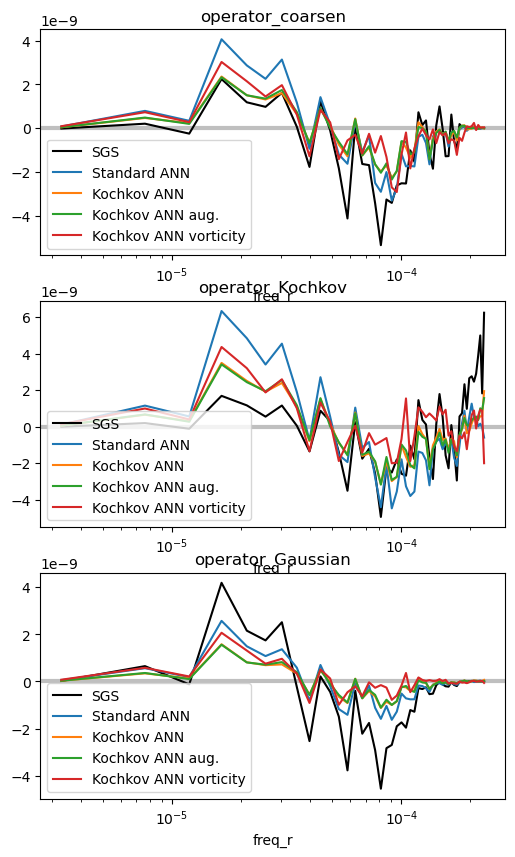

In [10]:
plt.figure(figsize=(6,10))
for row, (operator, title) in enumerate(zip([operator_coarsen, operator_Kochkov, operator_gaussian], ['operator_coarsen', 'operator_Kochkov', 'operator_Gaussian'])):
    dataset = ds.sample_epoch(time=time_id, operator=operator, factors=[2])[2]
    plt.subplot(3,1,row+1)
    kw_sp = dict(region='Pacific')
    dataset.state.transfer(dataset.data.SGSx, dataset.data.SGSy, **kw_sp).plot(color='k', label='SGS')
    # Standard ANN
    ann_Txy = import_ANN('trained_models/ANN_CM26/Txy_epoch_2000.nc')
    ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26/Txx_Tyy_epoch_2000.nc')
    dataset.state.transfer_ANN(ann_Txy, ann_Txx_Tyy, kw_sp=kw_sp).plot(label='Standard ANN')
    # Kochkov ANN
    ann_Txy = import_ANN('trained_models/ANN_CM26_Kochkov/Txy_epoch_2000.nc')
    ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26_Kochkov/Txx_Tyy_epoch_2000.nc')
    dataset.state.transfer_ANN(ann_Txy, ann_Txx_Tyy, kw_sp=kw_sp).plot(label='Kochkov ANN')

    # Kochkov ANN augmented
    ann_Txy = import_ANN('trained_models/ANN_CM26_Kochkov_augmented/Txy_epoch_100.nc')
    ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26_Kochkov_augmented/Txx_Tyy_epoch_100.nc')
    dataset.state.transfer_ANN(ann_Txy, ann_Txx_Tyy, kw_sp=kw_sp).plot(label='Kochkov ANN aug.')

    # Kochkov ANN vorticity
    ann_Txy = import_ANN('trained_models/ANN_CM26_Kochkov_vorticity/Txy_epoch_100.nc')
    ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26_Kochkov_vorticity/Txx_Tyy_epoch_100.nc')
    dataset.state.transfer_ANN(ann_Txy, ann_Txx_Tyy, kw_sp=kw_sp).plot(label='Kochkov ANN vorticity')

    
    plt.xscale('log')
    plt.axhline(y=0, color='gray', alpha=0.5, lw=3, zorder=-1)
    plt.legend()
    plt.title(title)